# **Image classification**
Machine learning project for image classification using different types of models. I used 'MedMNIST-Pneumonia' data set for training.
The aim of this project is to train and evaluate one or more classification models in order to establish if the lungs in the images are affected by pneumonia or not.

In [188]:
!pip install keras_tuner

Cell that groups all the libraries used for this project

In [189]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import random
from IPython.display import Markdown, display
from glob import glob
from PIL import Image
import os
import cv2

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, auc, confusion_matrix, classification_report, f1_score
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV

import tensorflow as tf
from tensorflow import keras
import keras_tuner
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from keras import regularizers, optimizers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K

In [190]:
# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

I loaded the dataset. The images are stored in the file 'pneumonia_images' and the labels in 'pneumonia_labels'.

In [191]:
# Uploading dataset MedMNIST
try:
    X = np.load("/content/drive/MyDrive/pneumonia_images.npy")
    y = np.load("/content/drive/MyDrive/pneumonia_labels.npy")
except FileNotFoundError:
    print("File not found. Make sure you have the correct path")
    exit()

This code snippet counts the number of normal and pneumonia images, displays a sample of each class, and shows the class distribution.

Image shape: (28, 28)
Total normal images: 1349
Total pneumonia images: 3883
Total images: 5232


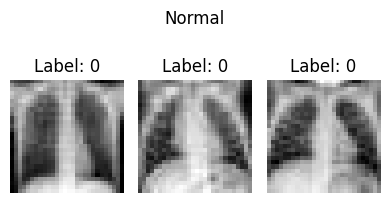

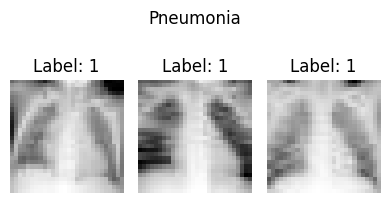

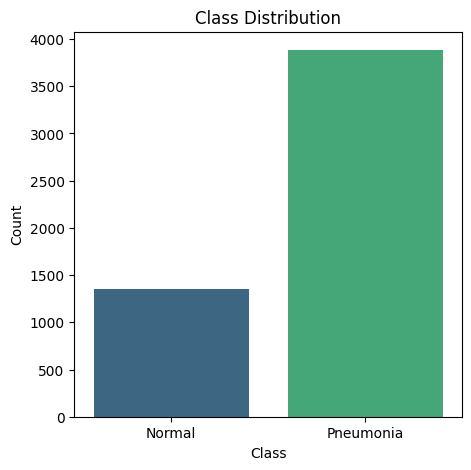

In [192]:
# Check the resolution of images
print(f'Image shape: {X[0].shape}')

# Count the number of images in each class
normal_images_count = np.sum(y == 0)
pneumonia_images_count = np.sum(y == 1)

print(f'Total normal images: {normal_images_count}')
print(f'Total pneumonia images: {pneumonia_images_count}')
print(f'Total images: {normal_images_count + pneumonia_images_count}')

# Function to display some images
def show_images(images, labels, label, title):
    plt.figure(figsize=(4,4))
    indices = np.where(labels == label)[0][:3]  # Get the first 6 indices of the specified label
    for i, idx in enumerate(indices):
        plt.subplot(2, 3, i + 1)
        plt.imshow(images[idx], cmap='gray')
        plt.axis('off')
        plt.title(f'Label: {label}')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Display some normal images
show_images(X, y, 0, 'Normal')

# Display some pneumonia images
show_images(X, y, 1, 'Pneumonia')

# Distribution of classes
labels = ['Normal', 'Pneumonia']
counts = [normal_images_count, pneumonia_images_count]
data = pd.DataFrame({'Class': labels, 'Count': counts})

plt.figure(figsize=(5, 5))
sns.barplot(x='Class', y='Count', data=data, palette='viridis', hue='Class', dodge=False, legend=False)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

The graphic underlines that the data set contains much more pneumonia images than normal ones.

I randomly split the dataset into training set, validation set and test set. The training set is used to train the different models, the validation set to calculate the errors on new predictions and the test set to verify the performance of the best models on new data. The split I used is approximately: 70% training set, 15% validation set and 15% test set.

I used the function train_test_split, offered by Scikit-learn for this task, to do a first split of the data and then I did a second split of the temporary set to create all the three sets.
I used stratify to take into account the imbalance in the number of normal and pneumonia images and maintain this proportion during the split.

In [193]:
# Division of dataset in training, validation e test set
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_validation, X_test, y_validation, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

I normalized the images to prevent data leakage.

In [194]:
# Normalization
X_train = X_train / 255.0
X_validation = X_validation / 255.0
X_test = X_test / 255.0

In [195]:
# Flattening the labels in 1D array
y_train = y_train.ravel()
y_validation = y_validation.ravel()
y_test = y_test.ravel()

I added a channel for the images, because the CNNs used require it.

In [196]:
# Add a channel for grayscale images
X_train = np.expand_dims(X_train, axis=-1)
X_validation = np.expand_dims(X_validation, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

In [197]:
print("Training set dimension:", X_train.shape)
num_samples, height, width, channels = X_train.shape
print("Number of samples:", num_samples)
print("Image height:", height)
print("Image width:", width)
print("Image number of channels:", channels)

print("\nValidation set dimension:", X_validation.shape)
num_samples, height, width, channels = X_validation.shape
print("Number of samples:", num_samples)
print("Image height:", height)
print("Image width:", width)
print("Image number of channels:", channels)

print("\nTest set dimension:", X_test.shape)
num_samples, height, width, channels = X_test.shape
print("Number of samples:", num_samples)
print("Image height:", height)
print("Image width:", width)
print("Image number of channels:", channels)


Training set dimension: (3662, 28, 28, 1)
Number of samples: 3662
Image height: 28
Image width: 28
Image number of channels: 1

Validation set dimension: (785, 28, 28, 1)
Number of samples: 785
Image height: 28
Image width: 28
Image number of channels: 1

Test set dimension: (785, 28, 28, 1)
Number of samples: 785
Image height: 28
Image width: 28
Image number of channels: 1


# **Random Forest**

In this section, I trained a Random Forest classifier on my training set. I used the technique of exhaustive parameter search via GridSearchCV to optimize the model's f1 score. I preferred this metric due to the classes distribution on the data.

In [198]:
# Random Forest model
rf_model = RandomForestClassifier(random_state=42)  # 42 is the seed
rf_param_grid = {'n_estimators': [100], 'max_depth': [None]} # 100 trees
rf_grid_search = GridSearchCV(rf_model, rf_param_grid, cv=5, scoring='f1')

# Training Random Forest
rf_grid_search.fit(X_train.reshape(len(X_train), -1), y_train) # Random Forest requires flattened images

# Considering which model is the best using validation set
rf_model_best = rf_grid_search.best_estimator_
rf_pred = rf_model_best.predict(X_validation.reshape(len(X_validation), -1))
rf_accuracy = accuracy_score(y_validation, rf_pred)
rf_f1_score = f1_score(y_validation, rf_pred)
rf_conf_matrix = confusion_matrix(y_validation, rf_pred)
rf_class_report = classification_report(y_validation, rf_pred)

# Predictions for the test set
rf_pred_test = rf_model_best.predict(X_test.reshape(len(X_test), -1))
rf_accuracy_test = accuracy_score(y_test, rf_pred_test)
rf_f1_score_test = f1_score(y_test, rf_pred_test)
rf_conf_matrix_test = confusion_matrix(y_test, rf_pred_test)
rf_class_report_test = classification_report(y_test, rf_pred_test)


I considered accuracy and F1 score as metrics to decide how this model worked.

The evaluation have been made on the validation set and on the test set to guarantee the model is not overfitting the data.
I obtained high scores for the validation set and similar scores for the test set, so I can says the model has good generalization properties.


In [199]:
print("Random Forest chosen:", rf_model_best)
print("\nAccuracy Random Forest (validation):", rf_accuracy)
print("F1 score Random Forest (validation):", rf_f1_score)

print("\nAccuracy Random Forest (test):", rf_accuracy_test)
print("F1 score Random Forest (test):", rf_f1_score_test)

Random Forest chosen: RandomForestClassifier(random_state=42)

Accuracy Random Forest (validation): 0.9477707006369427
F1 score Random Forest (validation): 0.9651656754460493

Accuracy Random Forest (test): 0.9426751592356688
F1 score Random Forest (test): 0.9618966977138018


Here is a visual representation of the confusion matrix, which says that the most part of the images has been correctly classificated.

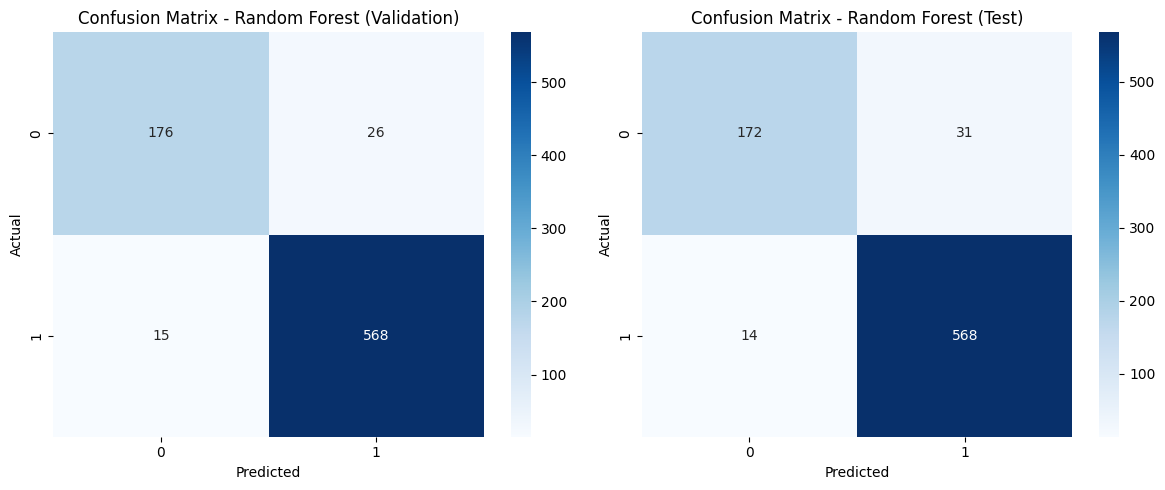

In [200]:
# Create a figure with a specified size
plt.figure(figsize=(12, 5))

# Create the first subplot in a 1x2 grid
plt.subplot(1, 2, 1)  # 1 row, 2 columns, subplot 1
sns.heatmap(rf_conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix - Random Forest (Validation)')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Create the second subplot in the same 1x2 grid
plt.subplot(1, 2, 2)  # 1 row, 2 columns, subplot 2
sns.heatmap(rf_conf_matrix_test, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix - Random Forest (Test)')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

# **Convolutional Neural Network**

In this Early Stopping definition, training stops if the validation loss function doesn't improve for 6 epochs and restore the weights to the values they had with the lower loss function. I decided to use Early Stopping to improve the efficiency and prevent overfitting, reducing also training time.

In [201]:
# Definition of early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

To use F1 score as a metric during the training of my CNN model, I needed to define it as a custom metric because it's not directly available as a standard metric to use during the NN training.

In [202]:
# Definition of f1 score
def f1_score_metric(y_true, y_pred):
    y_pred_binary = tf.round(y_pred)
    TP = tf.reduce_sum(y_true * y_pred_binary)
    FP = tf.reduce_sum((1 - y_true) * y_pred_binary)
    FN = tf.reduce_sum(y_true * (1 - y_pred_binary))

    precision = TP / (TP + FP + tf.keras.backend.epsilon())
    recall = TP / (TP + FN + tf.keras.backend.epsilon())

    f1_score = 2 * precision * recall / (precision + recall + tf.keras.backend.epsilon())
    f1_score = tf.clip_by_value(f1_score, 0.0, 1.0)

    return f1_score


The CNN model is defined using the Sequential API from Keras. It consists of convolutional layers (Conv2D) for feature extraction, followed by max pooling (MaxPooling2D) to reduce spatial dimensions. After flattening the feature maps, dense layers (Dense) with ReLU activation functions are employed for further feature processing. The output layer uses a sigmoid activation function to produce probabilities for binary classification.

In [203]:
# CNN model
CNN_model = Sequential([
    Conv2D(8, kernel_size=(3, 3), activation='relu',padding='same',input_shape=(28,28,1)),
    MaxPooling2D(pool_size=(2, 2),strides=2),
    Conv2D(16, kernel_size=(5, 5), activation='relu'),
    MaxPooling2D(pool_size=(2, 2),strides=2),
    Flatten(),
    Dense(120, activation='relu'),
    Dense(84, activation='relu'),
    Dense(1, activation='sigmoid')
])

CNN_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1_score_metric])
history_cnn = CNN_model.fit(X_train, y_train, epochs=100, validation_data=(X_validation, y_validation), callbacks=[early_stopping])


Epoch 1/100
115/115 [==============================] - 3s 11ms/step - loss: 0.4010 - accuracy: 0.8236 - f1_score_metric: 0.8915 - val_loss: 0.2195 - val_accuracy: 0.9096 - val_f1_score_metric: 0.9367
Epoch 2/100
115/115 [==============================] - 1s 6ms/step - loss: 0.1887 - accuracy: 0.9244 - f1_score_metric: 0.9483 - val_loss: 0.1540 - val_accuracy: 0.9299 - val_f1_score_metric: 0.9507
Epoch 3/100
115/115 [==============================] - 1s 6ms/step - loss: 0.1389 - accuracy: 0.9454 - f1_score_metric: 0.9605 - val_loss: 0.1213 - val_accuracy: 0.9465 - val_f1_score_metric: 0.9639
Epoch 4/100
115/115 [==============================] - 1s 5ms/step - loss: 0.1231 - accuracy: 0.9500 - f1_score_metric: 0.9658 - val_loss: 0.1401 - val_accuracy: 0.9427 - val_f1_score_metric: 0.9598
Epoch 5/100
115/115 [==============================] - 1s 5ms/step - loss: 0.1100 - accuracy: 0.9585 - f1_score_metric: 0.9715 - val_loss: 0.1153 - val_accuracy: 0.9490 - val_f1_score_metric: 0.9657
Epoc

Here is a representation of accuracy, F1 score and loss functions through the epochs on the training set and on the validation set.

The CNN has good performaces: high values for the accuracy and F1 score and low ones for the loss.

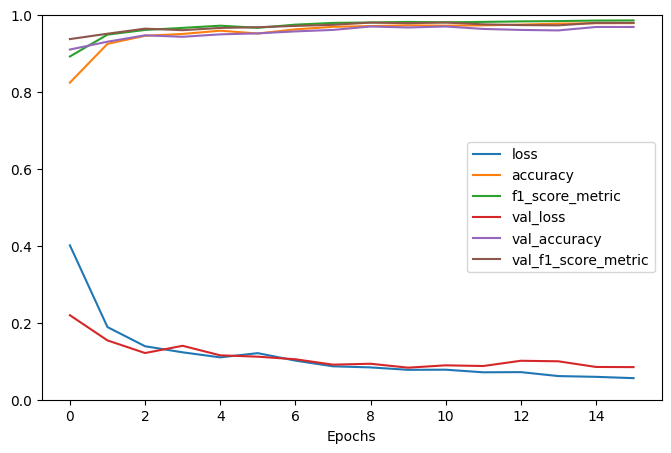

In [204]:
pd.DataFrame(history_cnn.history).plot(figsize=(8, 5))
plt.xlabel('Epochs')
plt.gca().set_ylim(0, 1)
plt.legend()
plt.show()

In [205]:
# validation set
y_pred_val_probs = CNN_model.predict(X_validation)
y_pred_val_cnn = np.round(y_pred_val_probs).astype(int)

f1_score_val_cnn = f1_score(y_validation, y_pred_val_cnn)
accuracy_val_cnn = accuracy_score(y_validation, y_pred_val_cnn > 0.5)

#test set
y_pred_test_probs = CNN_model.predict(X_test)
y_pred_test_cnn = np.round(y_pred_test_probs).astype(int)

f1_score_test_cnn = f1_score(y_test, y_pred_test_cnn)
accuracy_test_cnn = accuracy_score(y_test, y_pred_test_cnn > 0.5)

25/25 [==============================] - 0s 2ms/step


These metrics assert that the CNN has good properties of generalization, cause it has high values of accuracy and F1 score. And this values are similar for validation and test sets.

In [206]:
print("Accuracy CNN (validation):", accuracy_val_cnn)
print(f"F1 score CNN (validation): {f1_score_val_cnn}")

print("\nAccuracy CNN (test):", accuracy_test_cnn)
print(f"F1 score CNN (test): {f1_score_test_cnn}")

Accuracy CNN (validation): 0.9668789808917198
F1 score CNN (validation): 0.9777777777777777

Accuracy CNN (test): 0.9452229299363057
F1 score CNN (test): 0.9635901778154107


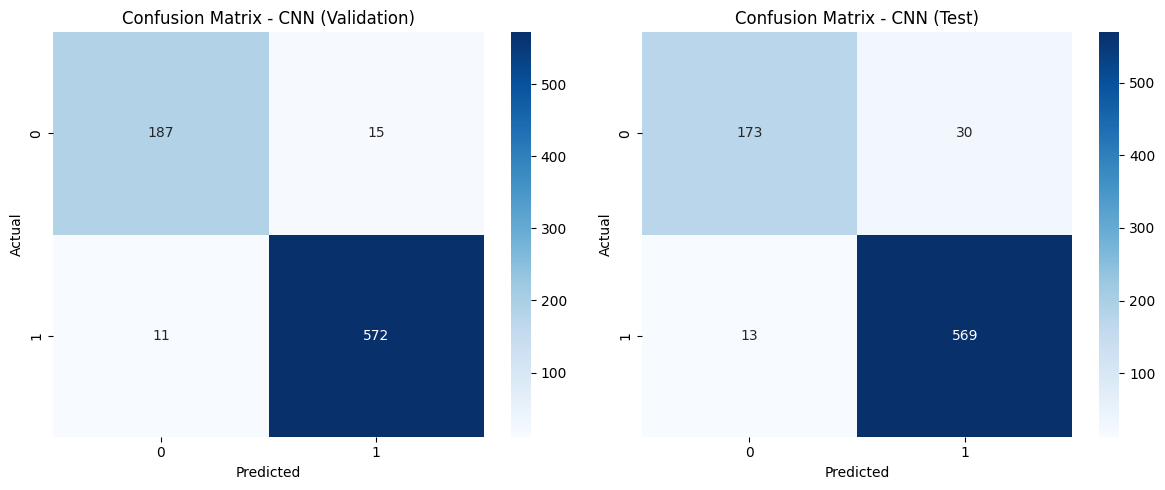

In [207]:
# Create a figure with a specified size
plt.figure(figsize=(12, 5))

# Create the first subplot in a 1x2 grid
plt.subplot(1, 2, 1)  # 1 row, 2 columns, subplot 1
sns.heatmap(confusion_matrix(y_validation, y_pred_val_cnn), annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix - CNN (Validation)')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Create the second subplot in the same 1x2 grid
plt.subplot(1, 2, 2)  # 1 row, 2 columns, subplot 2
sns.heatmap(confusion_matrix(y_test, y_pred_test_cnn), annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix - CNN (Test)')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

# Regularization

I applied a Gaussian filter to the images to make them robust to noise and help the model to generalize better. Adding noise can be seen as a form of Data Augmentation, which is useful given the small number of images in the data set.

In [208]:
# Function to apply Gaussian filter to the images
def apply_gaussian_filter(X, y):
    filtered_images = []
    for image in X:
        # Apply the filter to every image
        filtered_image = cv2.GaussianBlur(image, (3, 3), 0)
        filtered_images.append(filtered_image)
    return np.array(filtered_images), np.array(y)

filtered_X_train, y_train = apply_gaussian_filter(X_train, y_train)
filtered_X_validation, y_validation = apply_gaussian_filter(X_validation, y_validation)
filtered_X_test, y_test = apply_gaussian_filter(X_test, y_test)

I retrained the CNN on the new data.

In [209]:
CNN_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1_score_metric])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Training the model with filtered data
history_fil = CNN_model.fit(filtered_X_train, y_train, epochs=100, validation_data=(filtered_X_validation, y_validation), callbacks=[early_stopping])

Epoch 1/100
115/115 [==============================] - 2s 7ms/step - loss: 0.0883 - accuracy: 0.9661 - f1_score_metric: 0.9770 - val_loss: 0.0839 - val_accuracy: 0.9669 - val_f1_score_metric: 0.9779
Epoch 2/100
115/115 [==============================] - 1s 5ms/step - loss: 0.0914 - accuracy: 0.9653 - f1_score_metric: 0.9766 - val_loss: 0.0918 - val_accuracy: 0.9605 - val_f1_score_metric: 0.9734
Epoch 3/100
115/115 [==============================] - 1s 7ms/step - loss: 0.0776 - accuracy: 0.9724 - f1_score_metric: 0.9803 - val_loss: 0.0769 - val_accuracy: 0.9669 - val_f1_score_metric: 0.9777
Epoch 4/100
115/115 [==============================] - 1s 8ms/step - loss: 0.0858 - accuracy: 0.9675 - f1_score_metric: 0.9776 - val_loss: 0.0973 - val_accuracy: 0.9605 - val_f1_score_metric: 0.9735
Epoch 5/100
115/115 [==============================] - 1s 8ms/step - loss: 0.0774 - accuracy: 0.9697 - f1_score_metric: 0.9795 - val_loss: 0.0953 - val_accuracy: 0.9592 - val_f1_score_metric: 0.9723
Epoch

In [210]:
# Calculate accuracy and f1 score for the validation set
filtered_y_pred_val_probs = CNN_model.predict(filtered_X_validation)
filtered_y_pred_val_cnn = np.round(filtered_y_pred_val_probs).astype(int)

filtered_accuracy_val_cnn = accuracy_score(y_validation, filtered_y_pred_val_cnn)
filtered_f1_score_val_cnn = f1_score(y_validation, filtered_y_pred_val_cnn)

# Calculate accuracy and f1 score for test set
filtered_y_pred_test_probs = CNN_model.predict(filtered_X_test)
filtered_y_pred_test_cnn = np.round(filtered_y_pred_test_probs).astype(int)

filtered_accuracy_test_cnn = accuracy_score(y_test, filtered_y_pred_test_cnn)
filtered_f1_score_test_cnn = f1_score(y_test, filtered_y_pred_test_cnn)


25/25 [==============================] - 0s 2ms/step


Comparing the metrics for the case without filters and the case whit Gaussian one, I can say that we had a little improvement, so I decided to use the filtered images.

In [211]:
# Without filter
print("CNN without filter:")
print("Accuracy CNN (validation):", accuracy_val_cnn)
print("Accuracy CNN (test):", accuracy_test_cnn)
print(f"F1 score CNN (validation): {f1_score_val_cnn}")
print(f"F1 score CNN (test): {f1_score_test_cnn}")

# With filter
print("\nCNN with filter:")
print("Accuracy CNN (validation):", filtered_accuracy_val_cnn)
print("Accuracy CNN (test):", filtered_accuracy_test_cnn)
print(f"F1 score CNN (validation): {filtered_f1_score_val_cnn}")
print(f"F1 score CNN (test): {filtered_f1_score_test_cnn}")

CNN without filter:
Accuracy CNN (validation): 0.9668789808917198
Accuracy CNN (test): 0.9452229299363057
F1 score CNN (validation): 0.9777777777777777
F1 score CNN (test): 0.9635901778154107

CNN with filter:
Accuracy CNN (validation): 0.975796178343949
Accuracy CNN (test): 0.9592356687898089
F1 score CNN (validation): 0.9837189374464438
F1 score CNN (test): 0.9726027397260274


Looking at the graphic, the model is working very well. The loss function for the validation set remains low during the epochs, while accuracy and F1 score are high. The curves are stables and this is a sign of good generalization, while, on the other hand, fluctuations are signs of overfitting.

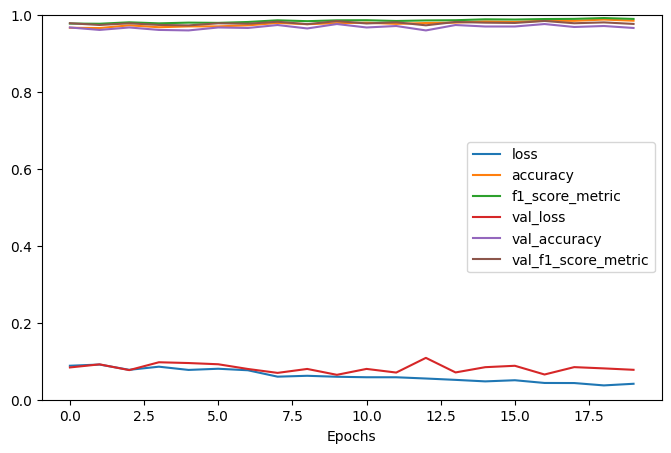

In [212]:
pd.DataFrame(history_fil.history).plot(figsize=(8, 5))
plt.xlabel('Epochs')
plt.gca().set_ylim(0, 1)
plt.legend()
plt.show()

# **Logistic regression**

As logistic regression works with 1D data, I flattened the features into a single vector for each data point.

In [213]:
# Reshape every image in X_train to use it in Logistic Regression Model
X_train_flat = np.array([image.reshape(-1) for image in X_train])

# Reshape every image in X_validation
X_validation_flat = np.array([image.reshape(-1) for image in X_validation])

# Reshape every image in X_test
X_test_flat = np.array([image.reshape(-1) for image in X_test])

In [214]:
# Create a logistic regression model
log_reg = LogisticRegression(solver='newton-cg')  # Newton's method for optimization. It's suitable for small to medium-sized datasets.

# Train the model on the training data
log_reg.fit(X_train_flat, y_train)

# Make predictions on the testing data
y_pred = log_reg.predict(X_test_flat)

# Evaluate the model
accuracy_val_log_reg = accuracy_score(y_validation, log_reg.predict(X_validation_flat))
f1_score_val_log_reg = f1_score(y_validation, log_reg.predict(X_validation_flat))
conf_matrix_val_log_reg = confusion_matrix(y_validation, log_reg.predict(X_validation_flat))

accuracy_log_reg = accuracy_score(y_test, y_pred)
f1_score_log_reg = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

This results point out the good performances of the Logistic Regression model.

In [215]:
# Print the evaluation results
print("Accuracy (validation):", accuracy_val_log_reg)
print("Accuracy (test):", accuracy_log_reg)
print("F1 score (validation):", f1_score_val_log_reg)
print("F1 score (test):", f1_score_log_reg)

Accuracy (validation): 0.9630573248407643
Accuracy (test): 0.954140127388535
F1 score (validation): 0.975107296137339
F1 score (test): 0.9693877551020409


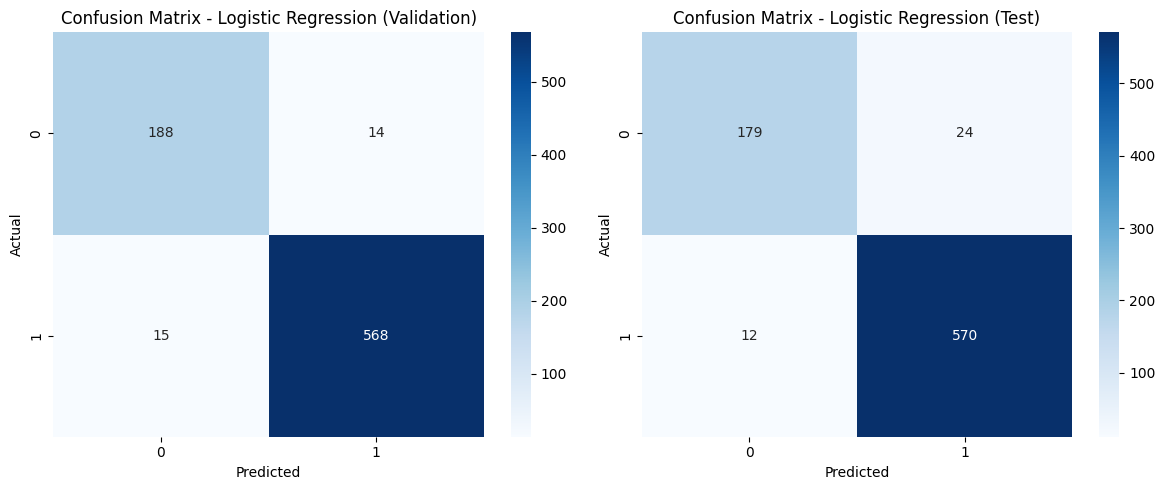

In [216]:
# Create a figure with a specified size
plt.figure(figsize=(12, 5))

# Create the first subplot in a 1x2 grid
plt.subplot(1, 2, 1)  # 1 row, 2 columns, subplot 1
sns.heatmap(conf_matrix_val_log_reg, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix - Logistic Regression (Validation)')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Create the second subplot in the same 1x2 grid
plt.subplot(1, 2, 2)  # 1 row, 2 columns, subplot 2
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix - Logistic Regression (Test)')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

# **Models comparison**

**Accuracy**

I plotted the accuracy for the previous models. The highest values is the CNN one, even if all models have an accuracy over 90%.

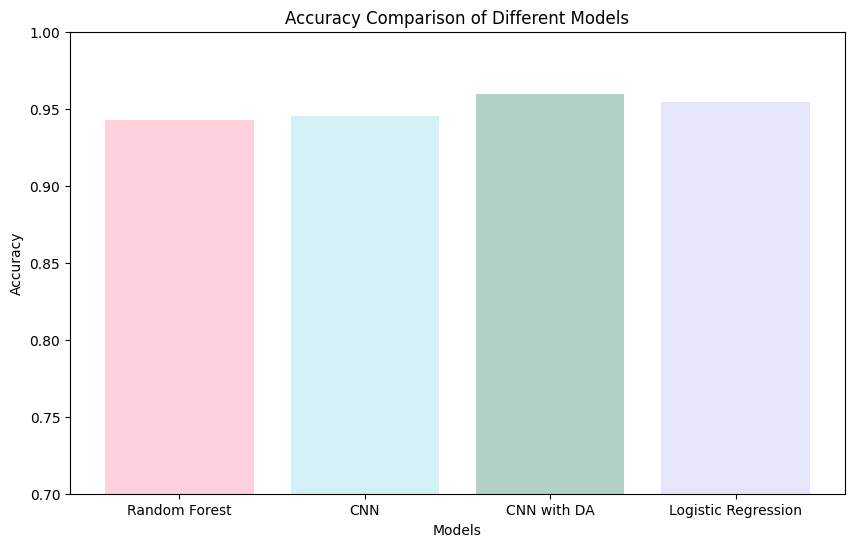

In [217]:
# Accuracy scores for each model
models = ['Random Forest', 'CNN', 'CNN with DA', 'Logistic Regression']
accuracy_scores = [rf_accuracy_test, accuracy_test_cnn, filtered_accuracy_test_cnn, accuracy_log_reg]  # Example accuracy scores

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(models, accuracy_scores, color = ["#ffd1dc", "#d3f0f7", "#b2d0c7", "#e6e6fa"])
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison of Different Models')
plt.ylim(0.7, 1)
plt.show()

In [218]:
# Create a dictionary to store predicted probabilities for each model
predicted_probs = {
    'Random Forest': rf_model_best.predict_proba(X_test.reshape(X_test.shape[0], -1))[:, 1],
    'CNN': CNN_model.predict(X_test),
    'CNN with DA': filtered_y_pred_test_probs,
    'Logistic Regression': log_reg.predict_proba(X_test.reshape(X_test.shape[0], -1))[:, 1],
}

25/25 [==============================] - 0s 3ms/step


**ROC Curve Analysis**

All the models achieved good results, the lower one is Random Forest, nevertheless its curve approaches the other ones.

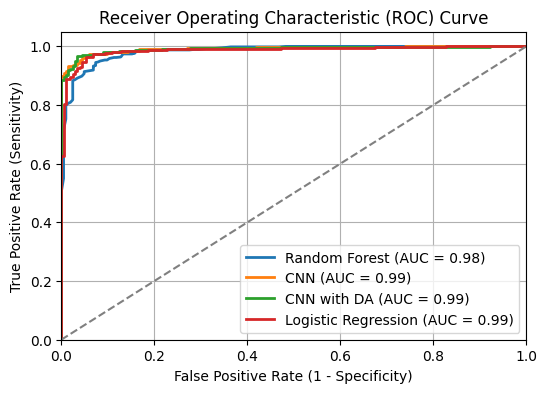

In [219]:
model_predictions = {
    'Random Forest': (predicted_probs['Random Forest'], y_test),
    'CNN': (predicted_probs['CNN'], y_test),
    'CNN with DA': (predicted_probs['CNN with DA'], y_test),
    'Logistic Regression': (predicted_probs['Logistic Regression'], y_test)
}

# Plot ROC curve for each model
plt.figure(figsize=(6, 4))
for model_name, (predicted_probs, y_test) in model_predictions.items():
    if predicted_probs.ndim == 1:  # If predicted_probs is a 1D array (binary classification)
        fpr, tpr, _ = roc_curve(y_test, predicted_probs)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.2f})')
    else:  # If predicted_probs is a 2D array (multiclass classification)
        # Assuming we have binary classification for each class vs the rest
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(predicted_probs.shape[1]):
            fpr[i], tpr[i], _ = roc_curve(y_test, predicted_probs[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
            plt.plot(fpr[i], tpr[i], lw=2, label=f'{model_name} (AUC = {roc_auc[i]:.2f})')

# Plot the random guessing line
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

# Set plot labels and title
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


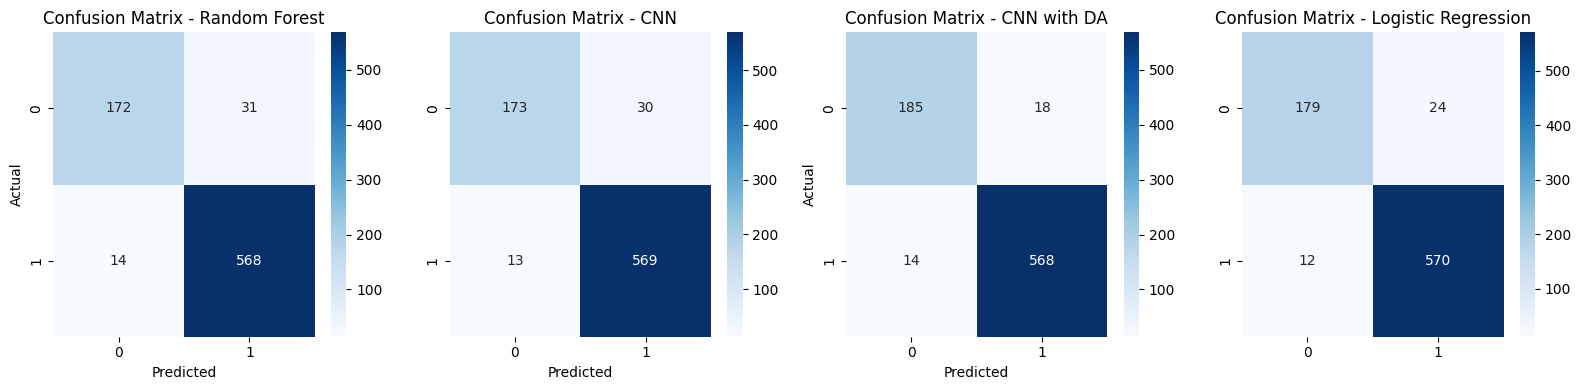

In [220]:
# Create a figure with a specified size
plt.figure(figsize=(16, 4))

plt.subplot(1, 4, 1)
sns.heatmap(confusion_matrix(y_test, rf_pred_test), annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(1, 4, 2)
sns.heatmap(confusion_matrix(y_test, y_pred_test_cnn), annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix - CNN')
plt.xlabel('Predicted')
plt

plt.subplot(1, 4, 3)
sns.heatmap(confusion_matrix(y_test, filtered_y_pred_test_cnn), annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix - CNN with DA')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(1, 4, 4)
sns.heatmap(confusion_matrix(y_test, log_reg.predict(X_test_scaled)), annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix - Logistic Regression')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

**F1-score**

F1-score is particularly useful for imbalanced datasets, where there might be a significant difference in the number of positive and negative examples. This is the case of MedMNIST Pneumonia data set, in which we have more pneumonia images than normal ones, as showed at the beginning.

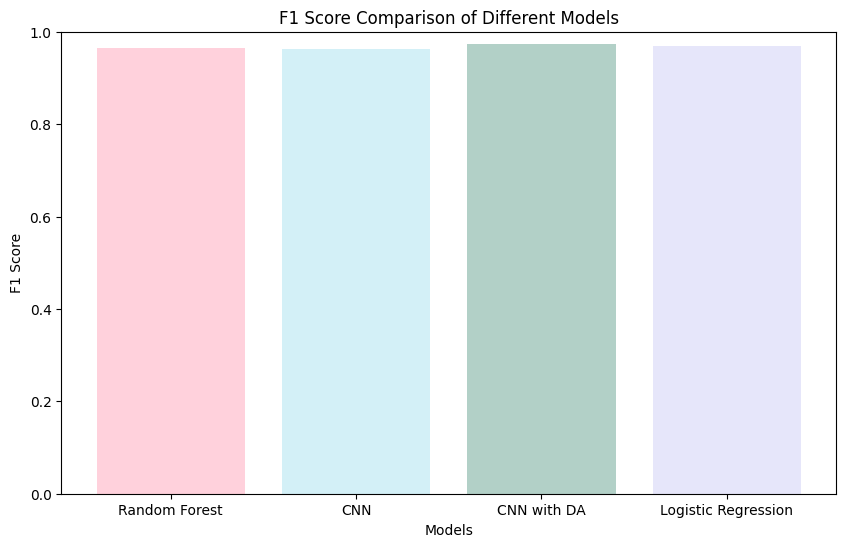

In [221]:
# F1 scores for each model
f1_scores = [rf_f1_score, f1_score_test_cnn, filtered_f1_score_test_cnn, f1_score_log_reg]

# Create a bar plot for F1 scores
plt.figure(figsize=(10, 6))
plt.bar(models, f1_scores, color=["#ffd1dc", "#d3f0f7", "#b2d0c7", "#e6e6fa"])
plt.xlabel('Models')
plt.ylabel('F1 Score')
plt.title('F1 Score Comparison of Different Models')
plt.ylim(0, 1)
plt.show()


Using F1 score, I can assert that the best models are Random Forest and Logistic Regression.